# Calculate SEM Image Stats

See the [README](./README.md) for more details.

In [1]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get, do, curry, count, pluck
import pandas
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu

 ## Helper Functions

`fcompose` is a helper function that doesn't seem to be in Toolz, but seems to make writing function pipelines much easier, likewise, when working with lists of dictionaries and data frames, `mapdict` and `dfassing` seem useful.

In [2]:
fcompose = lambda *args: compose(*args[::-1])

mapdict = lambda **kwargs: map(lambda data: dict(**dict((k, f(data)) for k, f in kwargs.items()),
                                                 **data))

@curry
def dfassign(df, **kwargs):
    return df.assign(**dict(((k, f(df)) for k, f in kwargs.items())))


## View the Images

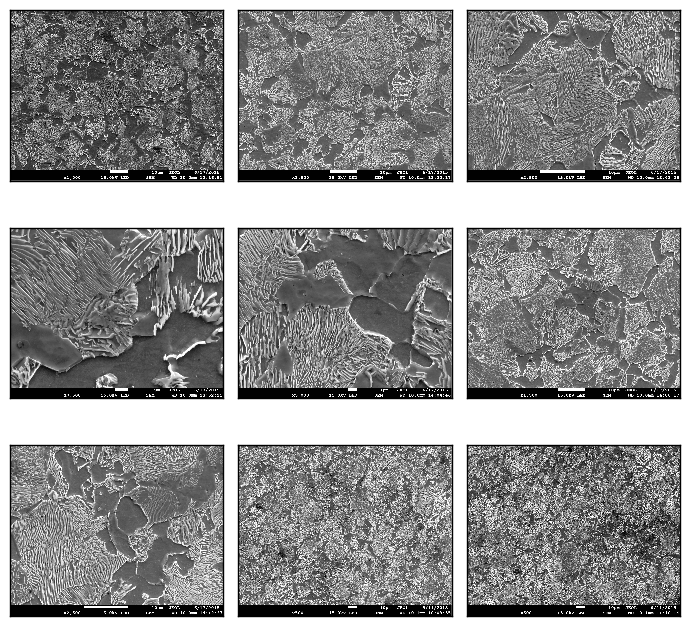

In [3]:
reshape = lambda arr: arr if len(arr.shape) == 2 else arr[...,0]
to_array = lambda image: reshape(np.asarray(image.convert("L")))

def plt_arrays(arrs):
    fig = plt.figure(figsize=(7, 7))
    N = int(np.ceil(np.sqrt(len(arrs))))
    for i, arr in enumerate(arrs):
        ax = fig.add_subplot(N, N, i + 1)
        out = ax.imshow(arr, cmap='Greys_r', interpolation='none')
        out.axes.get_xaxis().set_visible(False)
        out.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(to_array),
    list,
    plt_arrays
)

## Extract the Metadata

Each image has metadata embedded in the image. Here, `pytesseract` is used to extract this data. The images are cropped to split them into two upper and lower sections. The text extraction works better without the microstructure noise.

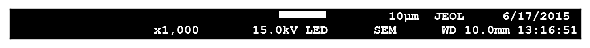

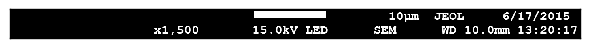

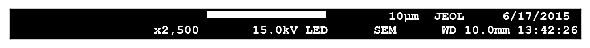

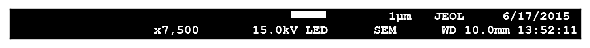

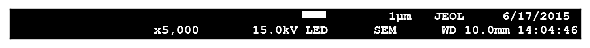

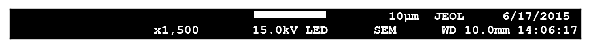

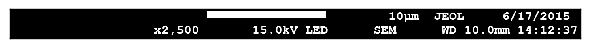

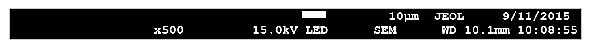

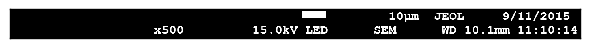

In [4]:
@curry
def crop_image(image, cutoff=960):
    return dict(
               upper=image.crop(box=(0, 0, image.size[0], cutoff)),
               lower=image.crop(box=(0, cutoff, image.size[0], image.size[1]))
           )

def plt_array(arr):
    ax = plt.imshow(arr, cmap='Greys_r', interpolation='none')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(PIL.Image.open),
    map(crop_image),
    pluck('lower'),
    map(to_array),
    map(
        do(
            plt_array
        )
    ),
    list
)

The metadata required from the images is the scale of the images. This requires the real scale size given by the number to the right of the scale bar and the size of the scale bar in pixels.

In [5]:
repair_string = lambda string: float('10' if string == 'mum' else string.replace('pm', ''))

scale_pixels = fcompose(
    to_array,
    lambda data: label(data, background=0),
    regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1]
)

extract_strings = fcompose(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
    get([1, 3, -1]),
    lambda data: dict(scale_microns=repair_string(data[0]),
                      date=data[1].replace('-', ''),
                      time=data[2])
)

extract_metadata = fcompose(
    PIL.Image.open,
    crop_image,
    get('lower'),
    lambda image: dict(scale_pixels=scale_pixels(image), **extract_strings(image))
)

out = pipe(
    'data/*.tif',
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename, **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame
)

print(out)

        date                            filename  scale_microns  scale_pixels  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif           10.0           107   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif           10.0           161   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif           10.0           267   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif            1.0            80   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif            1.0            54   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif           10.0           161   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif           10.0           267   
7  9/11/2015   data/20150911_1045_Nital_etch.tif           10.0            54   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif           10.0            54   

       time  
0  13:16:51  
1  13:20:17  
2  13:42:26  
3  13:52:11  
4  14:04:46  
5  14:06:17  
6  14:12:37  
7  10:08:55  
8  11:10:14  


## Rescale the Images

An array data point needs to have the same representation across all the images. This is done by rescaling the all the images to have the scale of the coarsest sampling.

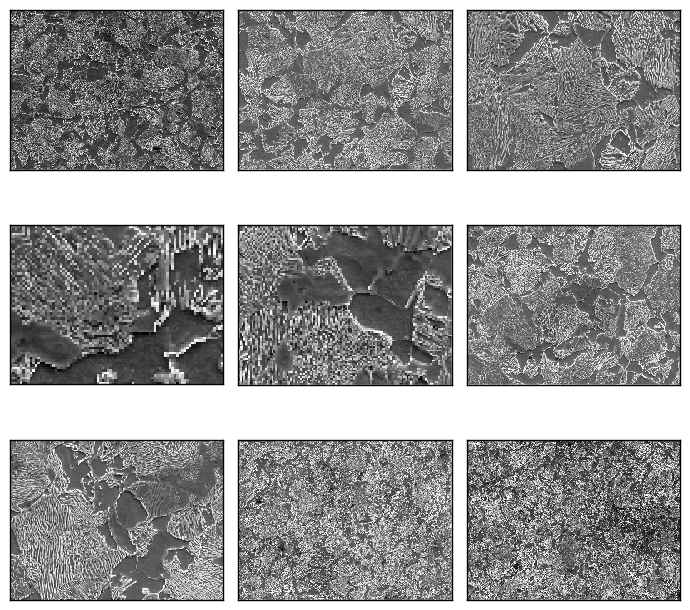

In [6]:
extract_image = fcompose(
    PIL.Image.open,
    crop_image,
    get('upper')
)

def scale_image(image, rescale_factor):
    copy_image = image.copy()
    copy_image.thumbnail(np.array(copy_image.size) * rescale_factor, PIL.Image.ANTIALIAS)
    return copy_image

get_df = fcompose(
    glob.glob,
    sorted,
    map(
        lambda filename: dict(filename=filename,
                              **extract_metadata(filename))
    ),
    list,
    pandas.DataFrame,
    dfassign(pixel_size=lambda df: df['scale_microns'] / df['scale_pixels']),
    dfassign(rescale_factor=lambda df: df['pixel_size'] / max(df['pixel_size'])),
)

scaled_images = fcompose(
    get_df,
    lambda df: df.T.to_dict().values(),
    mapdict(image=lambda data: extract_image(data['filename'])),
    mapdict(scaled_image=lambda data: scale_image(data['image'], data['rescale_factor'])),
    list
)

out = pipe(
    'data/*.tif',
    scaled_images,
    pluck('scaled_image'),
    map(to_array),
    list,
    plt_arrays
)

## Evaluate the Threshold Value

In [9]:
extract_threshold = fcompose(
    PIL.Image.open,
    crop_image,
    get('upper'),
    to_array,
    threshold_otsu
)

make_df_thresh = fcompose(
    lambda df: df.T.to_dict().values(),
    mapdict(threshold_value=lambda data: extract_threshold(data['filename'])),
    list,
    pandas.DataFrame
)

print(pipe('data/*.tif', get_df, make_df_thresh))

        date                            filename  pixel_size  rescale_factor  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif    0.093458        0.504673   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif    0.062112        0.335404   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif    0.037453        0.202247   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif    0.012500        0.067500   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif    0.018519        0.100000   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif    0.062112        0.335404   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif    0.037453        0.202247   
7  9/11/2015   data/20150911_1045_Nital_etch.tif    0.185185        1.000000   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif    0.185185        1.000000   

   scale_microns  scale_pixels  threshold_value      time  
0           10.0           107               98  13:16:51  
1           10.0           161              123  13:20:17  
2           10.0   

## Threshold the Images

/home/dwheeler/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


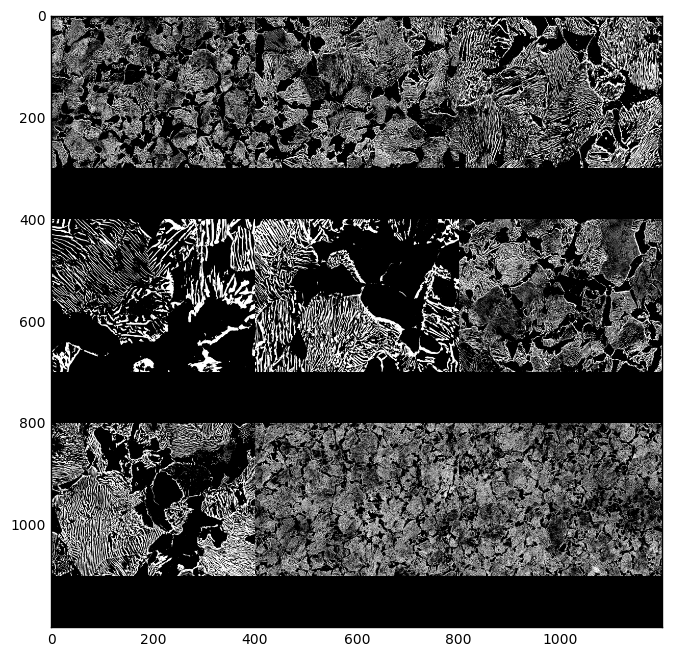

In [20]:
thresh_image = fcompose(
    crop,
    get(0),
    np.array,
    lambda data: data if len(data.shape) == 2 else data[...,0],
    lambda data: (data > threshold_otsu(data)).astype(float)
)

thresh_images = fcompose(
    lambda df: df['filename'],
    map(thresh_image),
)

to_pil = lambda data: PIL.Image.fromarray(np.uint8(data * 255))

make_thumb = fcompose(
    make_df,
    thresh_images,
    map(to_pil),
    list,
    combine_image(1200),
    np.array
)


fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(make_thumb("data/*.tif"))
fig.tight_layout()
fig.show()

